In [38]:
from plt_utils import *
from test_levels import *
import gym

print(gym.__version__)
# env = time_level()
env = trivial()

0.26.2


# Given env.P

## policy computation
- policy_update corresponds to $f_v$ <br>
- value_update(iterations =1) corresponds to $L_{\text{policy}}$ <br>
- value_update_seidel(iterations =1) uses updated values of v 
as soon that they are updated like gauss-seidel method. <br>

- value_iteration is applying $L_{f_v}v = Uv$ (theorem 1.3.5)  <br>
- backward_induction is value_iteration with $v^{T+1} =0$ and time dependence (theorem 1.2.1) <br>
- policy_iteration is generalized_iteration because of (theorem 1.3.6) <br>
we don't apply $L_{\pi}$ infinite times but to convergence or $1000$ 
iterations.

the code is obvious, there is a small difference in the formula <br> 
because rewards are defined differently so you take it in the sum <br>
that way you get averaged reward corresponding to our definition <br>
and you can decode $b$ with: <br>
env.P[state][action] = [(probability, nextstate, reward, done), ...] <br>
(To make backward induction time dependent just make env.P[state][action] 
time dependent.)


In [2]:
def states(env): return range(env.observation_space.n)
def actions(env, state): return env.P[state].keys()
# infmetric, norm, only works for v
def oometric(v1, v2): return max(abs(v1[i]-v2[i]) for i in v1.keys())

def value_update(env, alpha, v, policy, iterations=1, eps=10**(-4)):
    for _ in range(iterations): 
        vold = v.copy() 
        for state in states(env): 
            v[state] = sum(b[0]*(b[2]+alpha*vold[b[1]]) 
                           if not(b[3]) else b[0]*b[2] for b in env.P[state][policy[state]])
        if oometric(v, vold) < eps: break #convergence

def value_update_seidel(env, alpha, v, policy, iterations=1, eps=10**(-4)):
    for _ in range(iterations): 
        vold = v.copy() 
        for state in states(env): 
            v[state] = sum(b[0]*(b[2]+alpha*v[b[1]]) # v instead vold, an OG error  for finite problem
                           if not(b[3]) else b[0]*b[2] for b in env.P[state][policy[state]])
        if oometric(v, vold) < eps: break #convergence


def policy_update(env, alpha, v, policy):
    for state in states(env):
        max_a, max_val = 0, -float("inf") #to select the argmax
        for action in actions(env, state):
            val = sum(b[0]*(b[2]+alpha*v[b[1]]) if not(b[3]) else b[0]*b[2] for b in env.P[state][action])
            max_a, max_val = (action, val) if val > max_val else (max_a, max_val)
        policy[state] = max_a

def value_iteration(env,alpha,max_iter = 30,eps = 10**(-6)):
    v = {state:0 for state in states(env)} 
    policy = {state:0 for state in states(env)} 
    vv,pp = [],[] #these are for plotting

    for i in range(max_iter):
        policy_update(env,alpha,v,policy)
        value_update(env,alpha,v,policy,iterations=1)
        vv.append(v.copy()) # history of value functions
        pp.append(policy.copy()) # policy history
        if i>2 and oometric(vv[-1], vv[-2]) < eps: break
    return vv,pp

def backward_induction(env,alpha,T):
    return value_iteration(env,alpha,T,0)

def generalized_iteration(env,alpha,inner_iter=1,max_iter = 30,eps = 10**(-6)):
    v = {state:0 for state in states(env)} 
    policy = {state:0 for state in states(env)} 
    vv,pp = [],[] #these are for plotting

    for i in range(max_iter):
        value_update(env,alpha,v,policy,inner_iter,eps)
        policy_update(env,alpha,v,policy)
        vv.append(v.copy()) # history of value functions
        pp.append(policy.copy()) # policy history
        if i>2 and pp[-1]==pp[-2]==pp[-3]: break
    return vv,pp

def policy_iteration(env,alpha,max_iter = 30,eps = 10**(-6)):
    return generalized_iteration(env=env,alpha=alpha,inner_iter=10**3,max_iter = max_iter,eps = eps)

In [3]:
# bvv,bpp = backward_induction(env,alpha=1,T=1000) #programming task 1
vv,pp = policy_iteration(env,alpha=0.999,max_iter=50,eps=10**(-6)) #programming task 2
# vv,pp = value_iteration(env,alpha=0.999,max_iter=300,eps = 0.001) #programming task 3
sol = list(pp[-1].items()) # asked form of the policy
print(sol)
print(f"val(0) = {vv[-1][0]} at time 1 for finite horizon")
intvp(vv,pp)

[(0, 1), (1, 2), (2, 3), (3, 3), (4, 2), (5, 2), (6, 2), (7, 2), (8, 1), (9, 0), (10, 0), (11, 0), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 0), (18, 0), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 2), (43, 2), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 2), (60, 2), (61, 2), (62, 2), (63, 0)]
val(0) = 0.955359377777257 at time 1 for finite horizon


interactive(children=(IntSlider(value=0, description='iterations', max=17), IntSlider(value=0, description='ro…

## policy evaluation
value_eval is for evaluating a policy, basically it is a big  <br>
average of the rewards times the probability of getting it <br>
lot of terms can be reused, value_update does it basically 

In [4]:
def finite_value_eval(env,alpha,pp):
    v = {state:0 for state in states(env)} 
    vv= []
    for p in pp:
        value_update(env,alpha,v,p,1,0)
        vv.append(v.copy())
    print(f"val(0) = {vv[-1][0]} at time 1 for finite horizon")
    return vv

def infinite_value_eval(env,alpha,policy,eps=10**(-6)):
    v = {state:0 for state in states(env)} 
    value_update(env,alpha,v,policy,10**5,eps)
    print(f"val(0) = {v[0]} for infinite horizon")
    return v 

def random_policy(env,T):
    return [{state:env.action_space.sample() 
            for state in states(env)}
            for _ in range(T)]


In [5]:
pvv,ppp = policy_iteration(env,alpha=0.999,max_iter=50,eps=10**(-6)) 
pv = infinite_value_eval(env,0.999,ppp[-1])
print(f"reference = {pvv[-1][0]}")

val(0) = 0.9553523997340856 for infinite horizon
reference = 0.955359377777257


In [16]:
bvv,bpp = backward_induction(env,alpha=1,T=30) 
bbvv = finite_value_eval(env,1,bpp)
print(f"reference = {bvv[-1][0]}")

val(0) = 0.010874736571158946 at time 1 for finite horizon
reference = 0.010874736571158946


In [7]:
rpp = random_policy(env,2000)
rvv = finite_value_eval(env,1,rpp)

val(0) = 0.057083790103964104 at time 1 for finite horizon


# Simulation based
## MC evaluation
Evaluation is easy with MC estimation but it is really slow ...

In [8]:
def MC_eval(env,pol,alpha,T=10**3,nsim = 10**3):
    # does MC estimation of the expected reward
    running_sum = 0
    for _ in range(nsim):
        stat = env.reset()
        # state = env.reset() #google colab
        total_reward = 0
        state = stat[0]
        for t in range(T): 
            action = pol[t][state]
            state, reward, done, _, _ = env.step(action)
            total_reward += alpha**t*reward
            if done: break
        env.close()
        running_sum +=total_reward/nsim
    return running_sum

def infinite_pol_rep(p,T):
    return {t: {i:p[i] 
              for i in range(env.observation_space.n)}
                for t in range(T)}

def finite_pol_rep(pp,T):
    return {t: {i:pp[-t-1][i] 
              for i in range(env.observation_space.n)}
                for t in range(T)}


In [9]:
pvv,ppp = policy_iteration(env,alpha=0.999,max_iter=50,eps=10**(-6)) 
T = 10**3 # basically infinity
rep_ppp = infinite_pol_rep(ppp[-1],T)
pMC = MC_eval(env,rep_ppp,0.999,T,10**3)
print(f"MC eval = {pMC}")
print(f"reference = {pvv[-1][0]}")

MC eval = 0.9554627777139812
reference = 0.955359377777257


In [135]:
bvv,bpp = backward_induction(env,alpha=1,T=50) 
T = len(bpp)
rep_bpp = infinite_pol_rep(bpp[-1],T)
bMC = MC_eval(env,rep_bpp,1,T,10**3)
print(f"MC eval = {bMC}")
print(f"reference = {bvv[-1][0]}")

MC eval = 0.07600000000000005
reference = 0.07595414188519159


## Q-learning

We assume we know the states and the actions ...

val(0) = 0.0 for infinite horizon
val(0) = 0.0 for infinite horizon


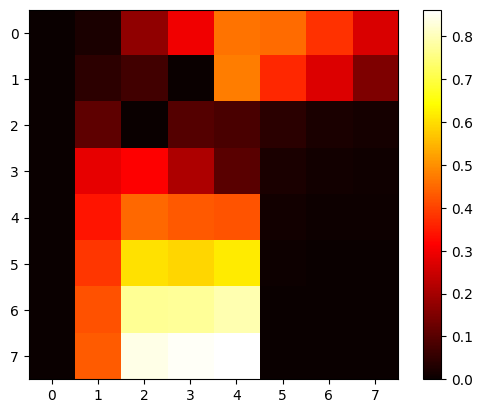

In [40]:
def get_action_from_q(q,state):
    max_a , max_val = 0, q[state][0]
    for action,val in q[state].items():
        max_a, max_val = (action, val) if val > max_val else (max_a, max_val)
    return max_a,max_val    

def get_q_from_v(env,v):
    q = {state:{action:0 for action in actions(env,state) } for state in states(env)}
    for state in states(env):
        for action in actions(env,state): 
            val = sum(b[0]*(b[2]+v[b[1]]) for b in env.P[state][action]) # uses P
            q[state][action]= val
    return q

def get_policy_from_q(env,q):
    return {state:get_action_from_q(q,state)[0] for state in states(env)}

def Q_learning(env,v,alpha,gamma,T=10**3,nsim = 10**3):
    q = get_q_from_v(env,v)
    for i in range(nsim):
        stat = env.reset()
        # state = env.reset() #google colab
        state = stat[0]
        for t in range(T): 
            action, qval = get_action_from_q(q,state)
            state, reward, done, _, _ = env.step(action)
            q[state][action] = (1-gamma)*(q[state][action])+ gamma*(reward+alpha*qval)
            if done: break
        env.close()
    return q 


bv = infinite_value_eval(env,1,bpp[10])

q= Q_learning(env,bv,1,1,T=10**3,nsim=10**2)
qv = infinite_value_eval(env,1,get_policy_from_q(env,q))
dv = {state:(qv[state]-bv[state]) for state in states(env)}
visv(dv)